In [46]:
%pip install japanize-matplotlib

Note: you may need to restart the kernel to use updated packages.


NameError: name 'x_time' is not defined

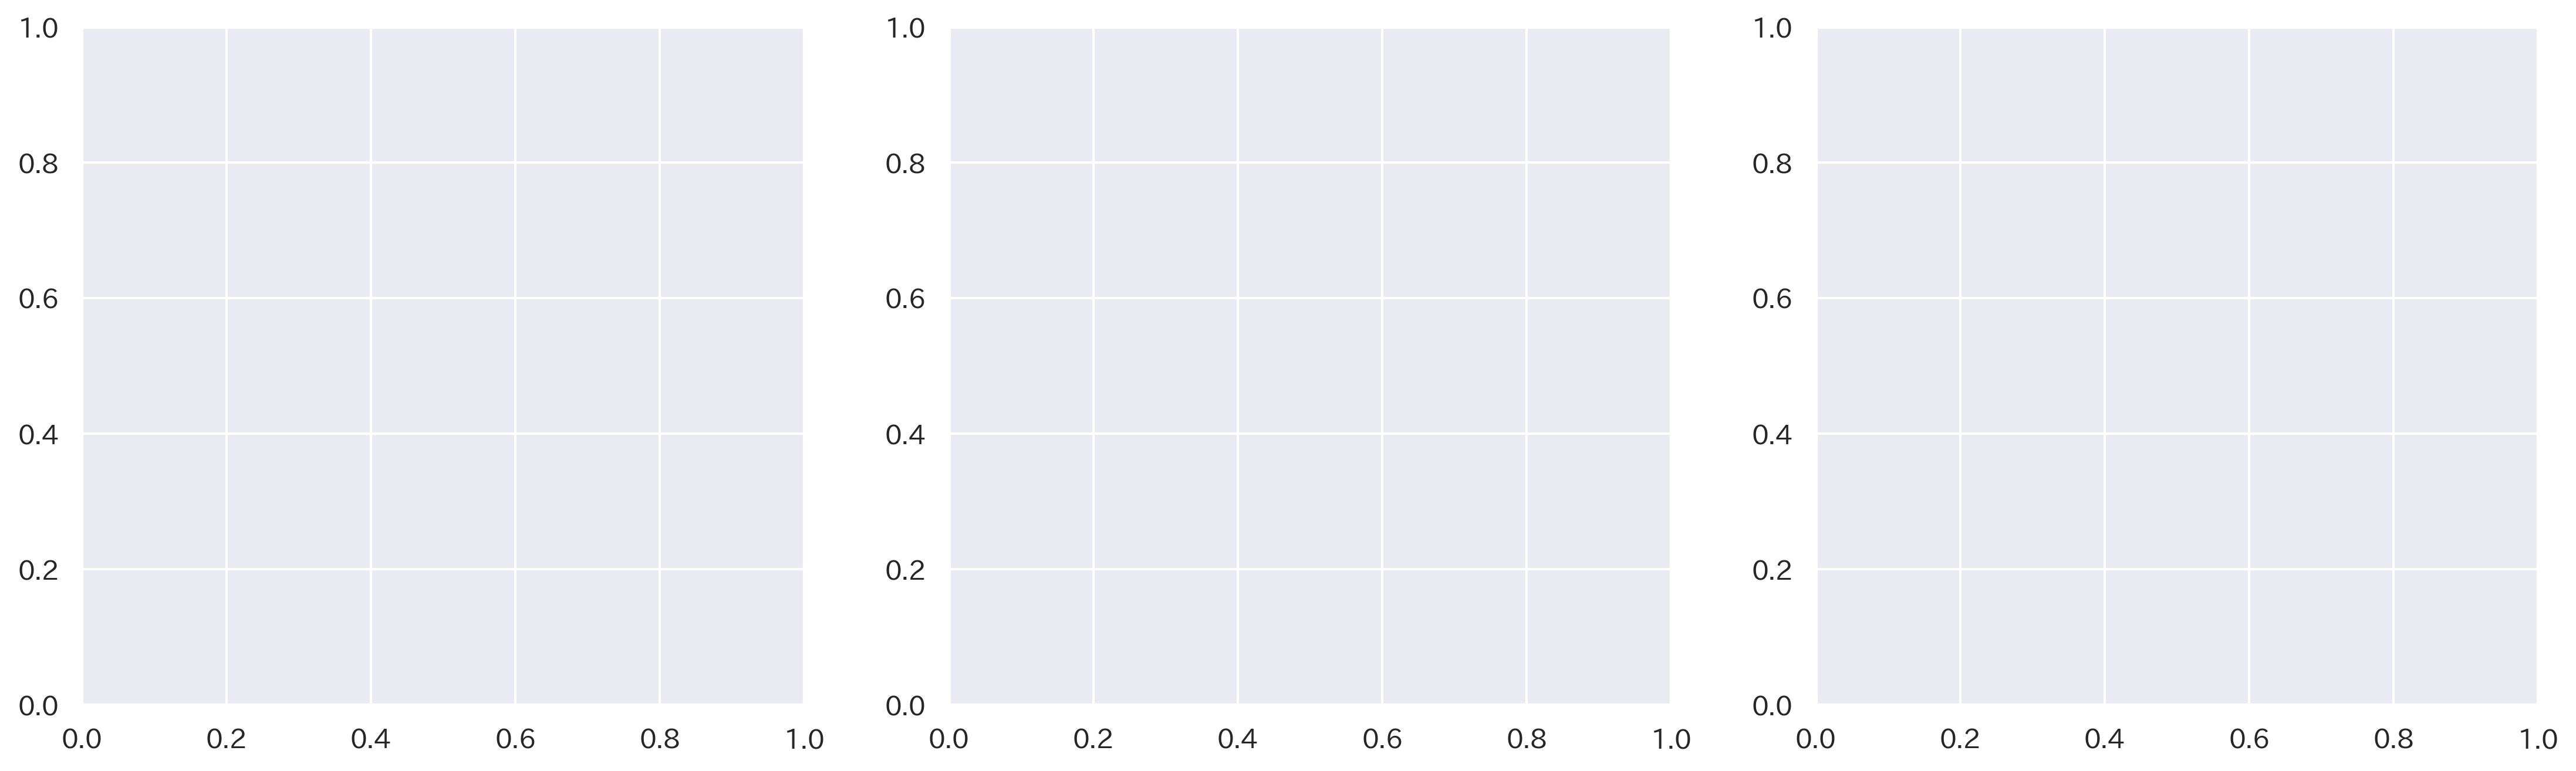

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#例えば、seaborn を利用している場合であれば sns.set() などで描画フォントが seaborn のデフォルトに上書きされ、日本語表示がされなくなります。
#sns.set(font="IPAexGothic") のように利用フォントに IPAexGothic を設定するか、フォント上書き後に japanize_matplotlib.japanize() を利用するなどで日本語表示できるはずです。
import japanize_matplotlib
japanize_matplotlib.japanize()
import pandas as pd
import os
import glob
import re
import shutil

#一つのグラフに入れるデータは、一つのディレクトリにまとめておく
data_directory = "/home/biofunc/data220122"


#グラフのラベル
graph_xlabel = 'time (min)'
graph_ylabel = ['ドパミン濃度 (pg/1μL)', 'ドパミン基準濃度からの変化率(倍)', 'ドパミン基準濃度からの変化量 (pg/1μL)']
graph_title = ['(a)ドパミン濃度の経時的変化', '(b)ドパミン基準濃度からの変化率の経時的変化', '(c)ドパミン基準濃度からの変化量の経時的変化']
graph_line_x = 270
graph_line_label = 'K+ACSFに切替え'

#グラフ作成
fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
x_time_range = x_time[sample_type_start_and_end[sample_order['baseline']][0] - len(data_str[0]) + 1: sample_type_start_and_end[sample_order['fruction']][1] - len(data_str[0]) + 1: 1]
for i in range(len(data)):
    str_model = LinearRegression(fit_intercept=False)
    str_model.fit(x_DAstr_pg[i][:, np.newaxis], data_str[i]) #スタンダード統一できたらここ調整
    str_fit = str_model.predict(x_DAstr_pg[i][:, np.newaxis])
    baseline = np.average(data_baseline[i]) / str_model.coef_[0]
    ax[0].plot(x_time_range, np.concatenate([data_baseline[i], data_fruction[i]]) / str_model.coef_[0], label=sample_name[i])
    ax[1].plot(x_time_range, np.concatenate([data_baseline[i], data_fruction[i]]) / (str_model.coef_[0] * baseline), label=sample_name[i])
    ax[2].plot(x_time_range, np.concatenate([data_baseline[i], data_fruction[i]]) / (str_model.coef_[0]) - baseline, label=sample_name[i])
    print(f'{sample_name[i]}の傾きは{str_model.coef_[0]}、決定係数R^2は{r2_score(data_str[i], str_fit)}')
    print(f"ベースラインのDA濃度は{baseline} pg/1ml")

#サンプル切替え時点ラインの挿入、横軸間隔、軸名、データ名の設定
for i in range(len(graph_ylabel)):
    ax[i].axvline(x=graph_line_x, color='black', linestyle=':', label=graph_line_label)
    ax[i].set(xlabel=graph_xlabel, ylabel=graph_ylabel[i], title=graph_title[i], xticks=x_time_range)
    ax[i].legend();

# テキストをテキストとして出力する設定
plt.rc("svg", fonttype="none")
# SVGとして保存
fig.savefig(os.path.join(data_directory, "sample.svg"))

In [103]:
path_to_RawData_folder = '/home/biofunc/data/ラット行動実験データ（生体機能・組織培養室PC）/Data'
def make_graph_from_xlsx(path_to_RawData_folder):
    path_to_graph_folder = path_to_RawData_folder + '/graph'
    if not os.path.exists(path_to_graph_folder):
        os.mkdir(path_to_graph_folder)
    elif os.path.exists(path_to_graph_folder):
        shutil.rmtree(path_to_graph_folder)
        os.mkdir(path_to_graph_folder)
    
    list_of_path_to_xlsx_folder = sorted(glob.glob(path_to_RawData_folder + '/xlsx_from_json' + '*'))

    #print('check point 1')
    #print(list_of_path_to_xlsx_folder)

    for a_path in list_of_path_to_xlsx_folder:
        # print(a_path)
        list_of_path_to_all_rats_xlsx = sorted(glob.glob(a_path + '/all_rats' + '*' + '.xlsx'))
        variation_of_this_folder = a_path.split('.')[1]
        largest_mod_num = 0
        a_path_to_all_rats_xlsx_largest_mod = ''
        for a_path in list_of_path_to_all_rats_xlsx:
            mod_num = re.findall('mod(\d+)', a_path)
            if int(mod_num[0]) > largest_mod_num:
                largest_mod_num = int(mod_num[0])
                a_path_to_all_rats_xlsx_largest_mod = a_path
        # print('check point 1')
        # print(a_path_to_all_rats_xlsx_largest_mod)

        # header=[0,1]で、1行目と2行目をヘッダーとして読み込む
        df_of_all_rats = pd.read_excel(a_path_to_all_rats_xlsx_largest_mod, header=[0,1], index_col=[0])
        # print('check point 2')
        # print(variation_of_this_folder)

        # make figure
        fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
        for a_data in df_of_all_rats.columns.get_level_values('data').unique():
            # 実験の種類を取得
            list_of_type_of_experiment = list(set([i.split('_')[0].upper() for i in df_of_all_rats[a_data].columns.get_level_values('subject').tolist()]))
            for a_type in range(len(list_of_type_of_experiment)):
                a_type_of_experiment = list_of_type_of_experiment[a_type]
                for a_subject in df_of_all_rats.columns.get_level_values('subject'):
                    if re.findall('(_std)', a_subject) != [] and re.findall('(_sem)', a_subject) == []:
                        #color mapは
                        color_of_average = plt.cm.tab20(i*2)
                        ax[0].plot(df_of_all_rats.index, df_of_all_rats[a_data][a_subject], label=a_subject, c=color_of_average)
                    elif re.findall('(_std)', a_subject) == [] and re.findall('(_sem)', a_subject) == []:
                        color_of_subject = plt.cm.tab20(i*2+1)
                        ax[0].plot(df_of_all_rats.index, df_of_all_rats[a_data][a_subject], label=a_subject, c=color_of_subject)









MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF
MIXED
DIFF


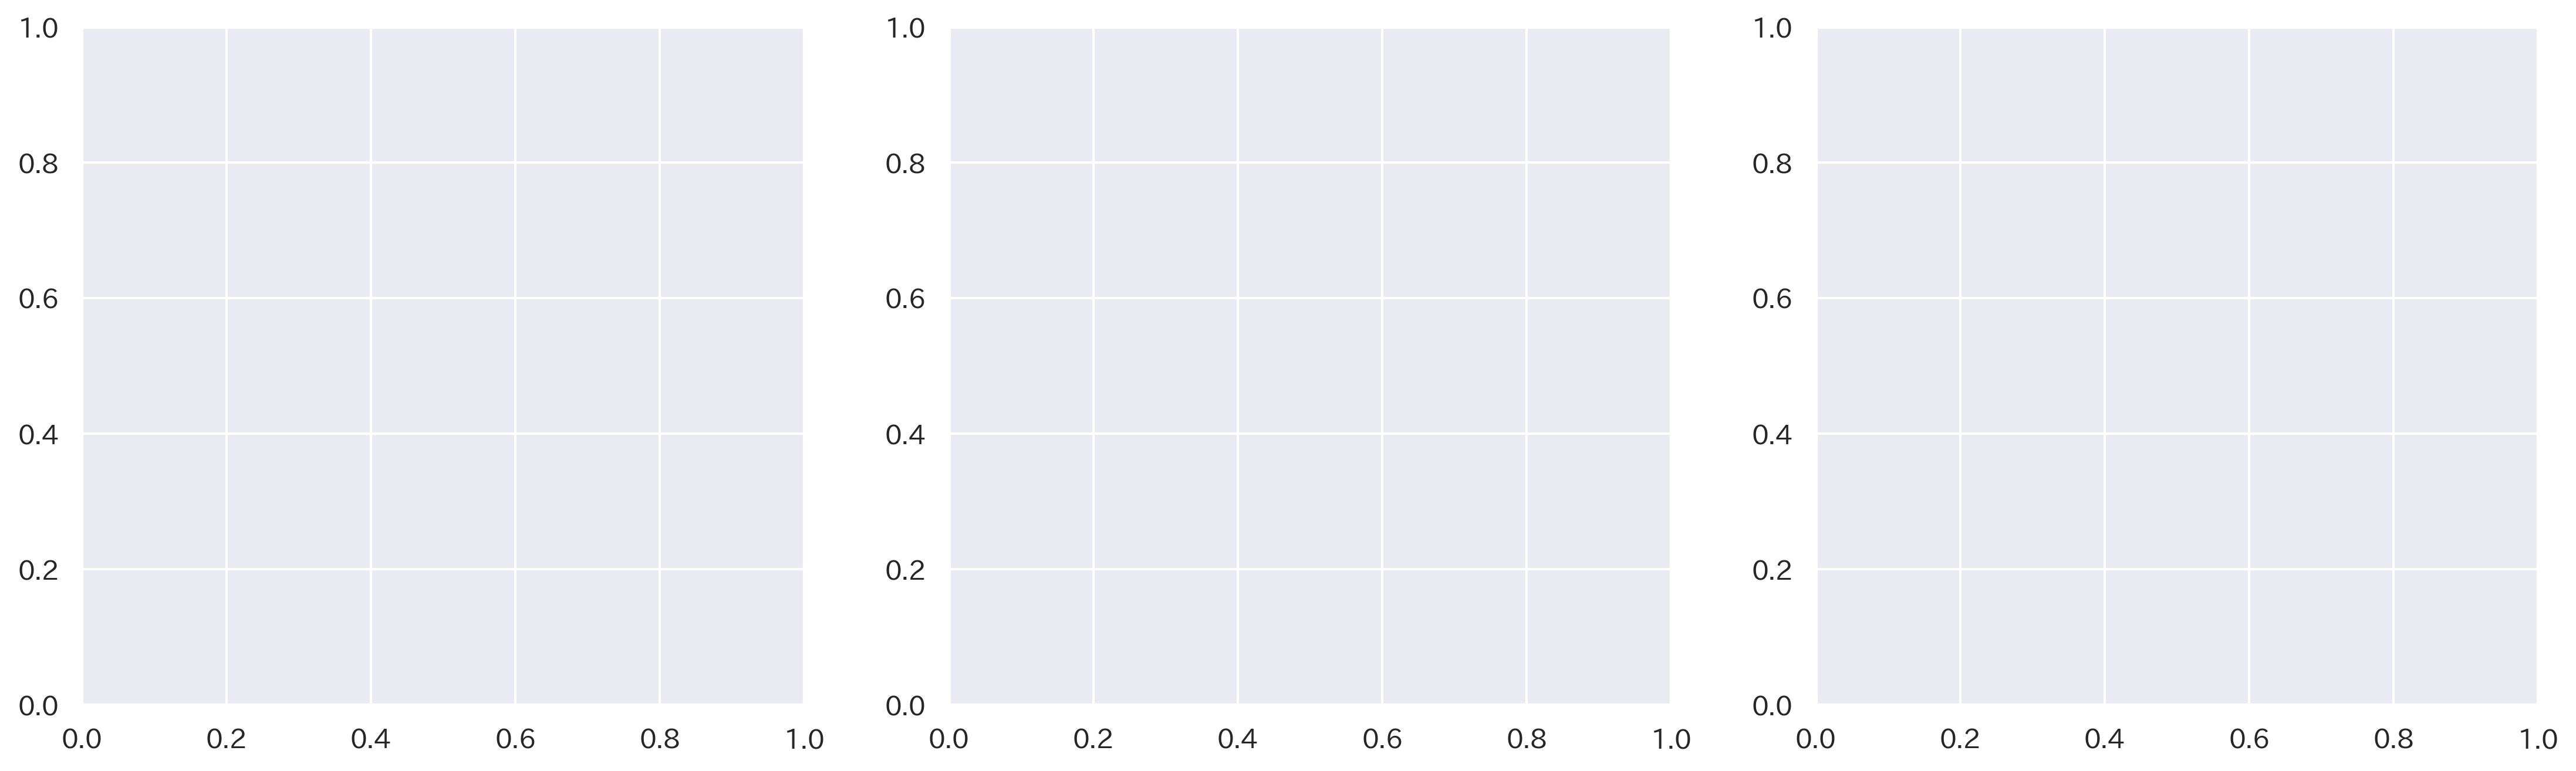

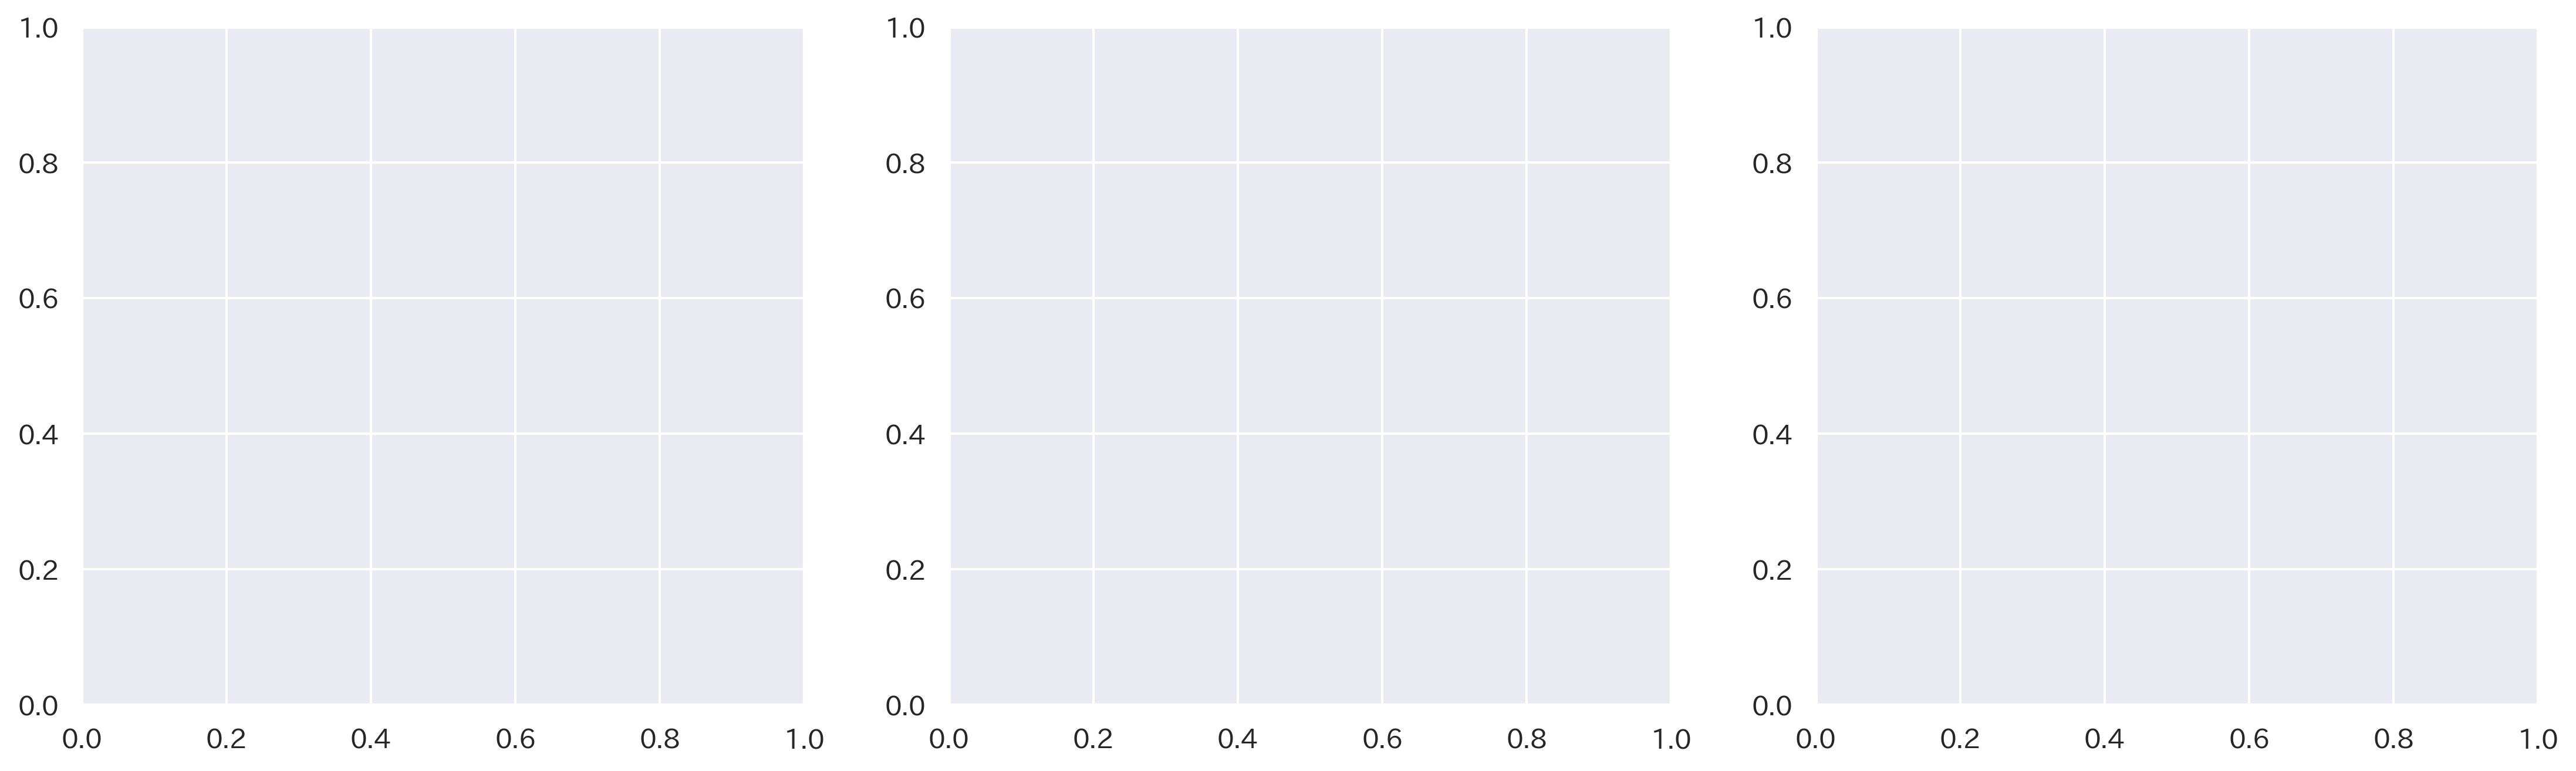

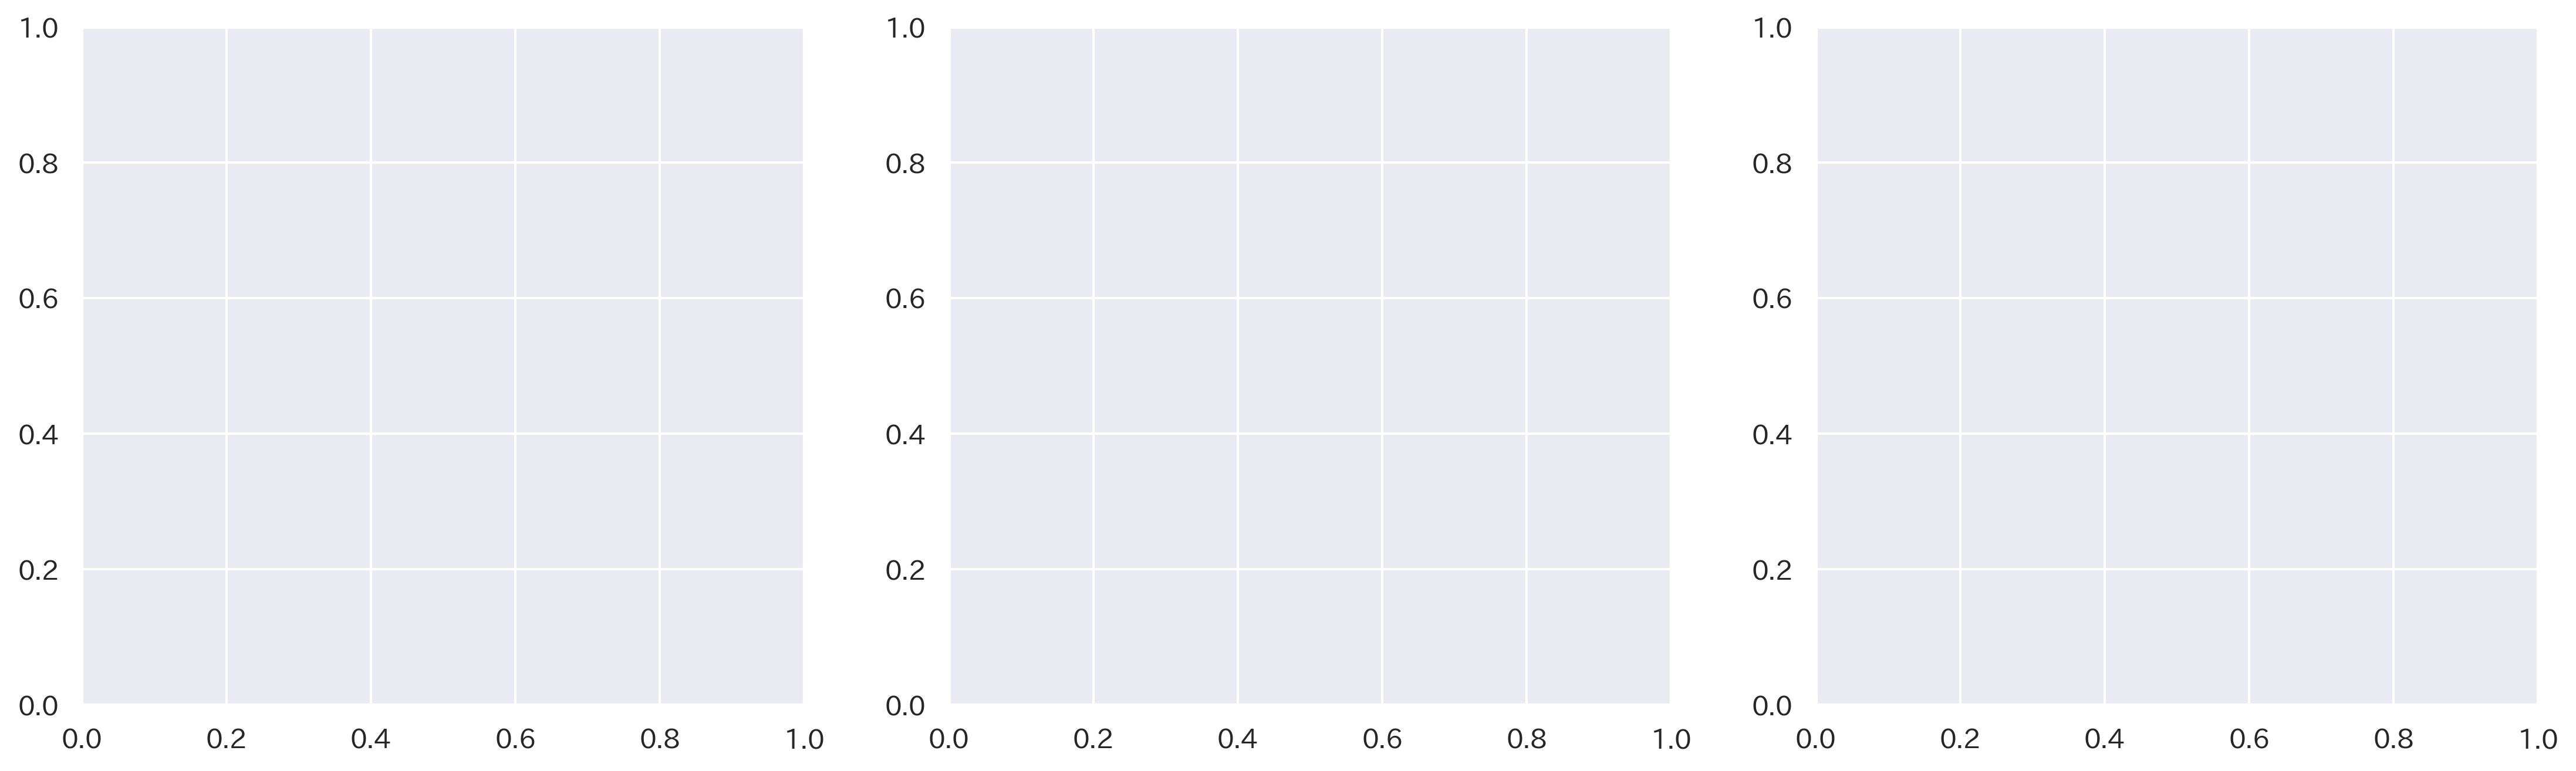

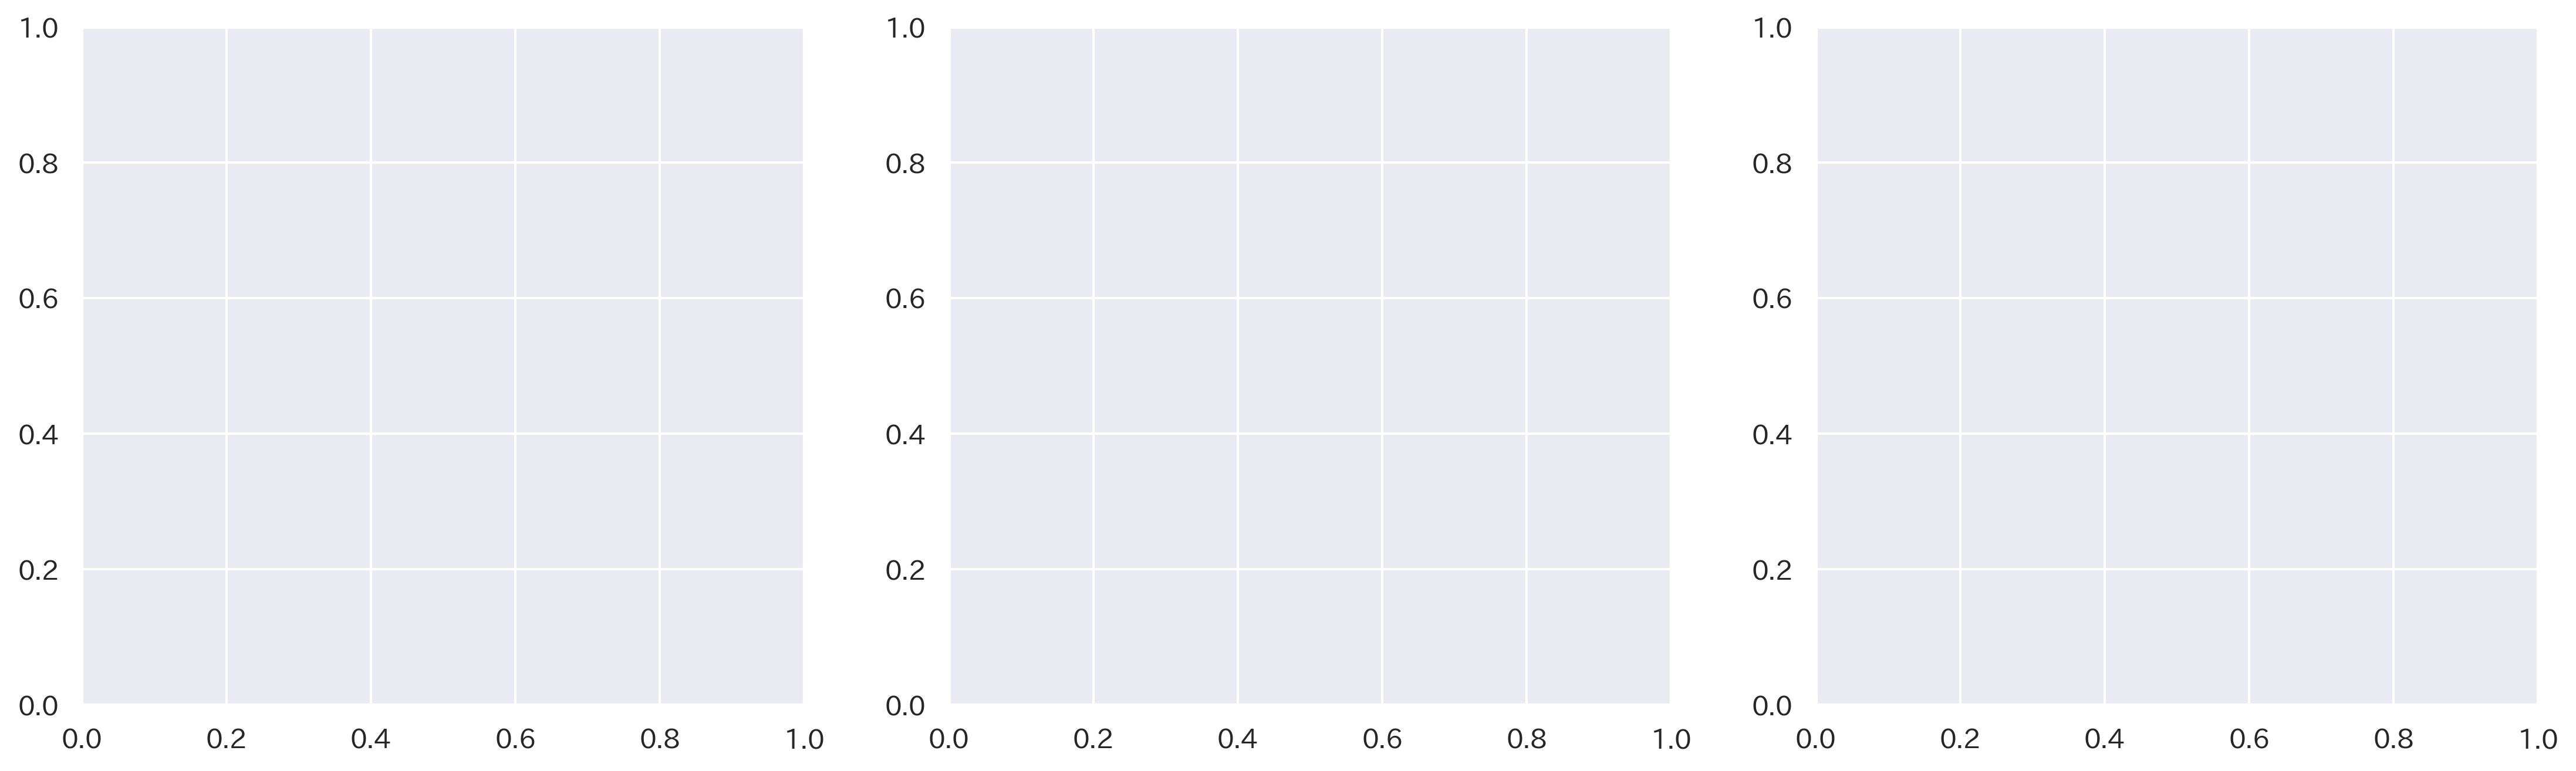

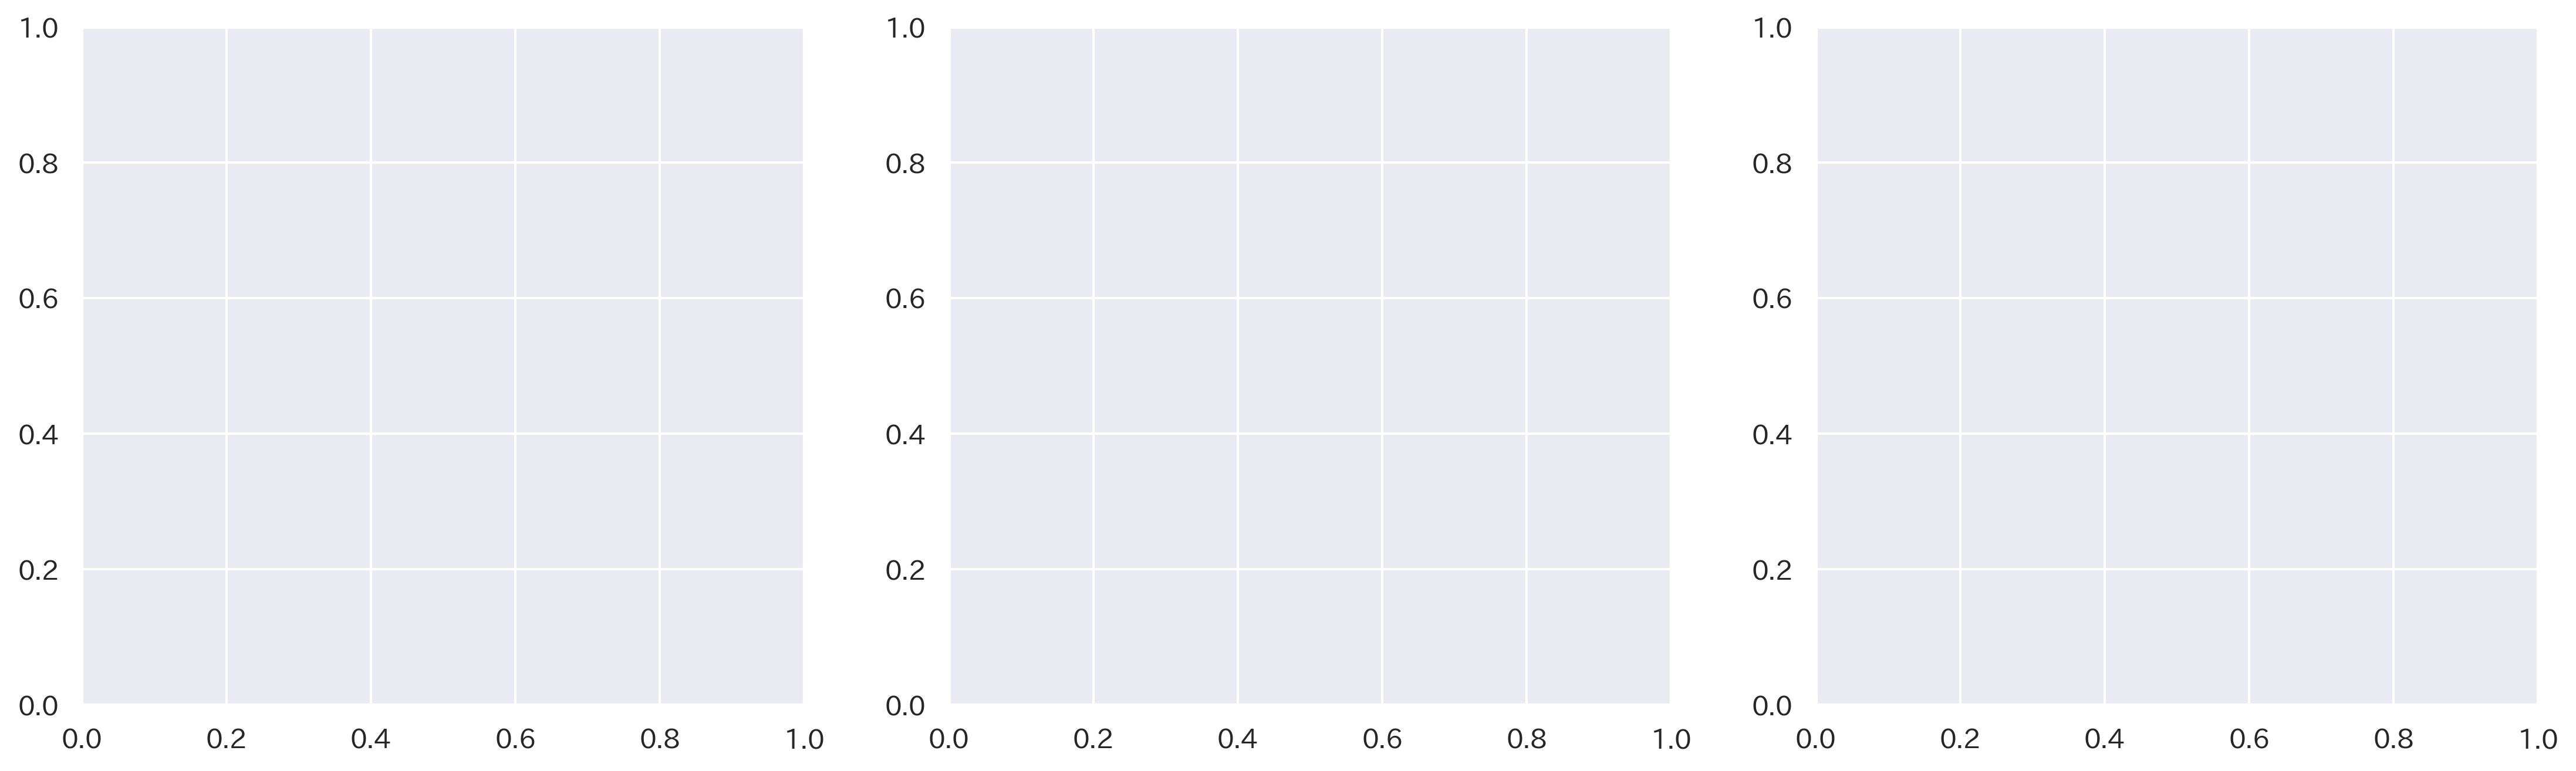

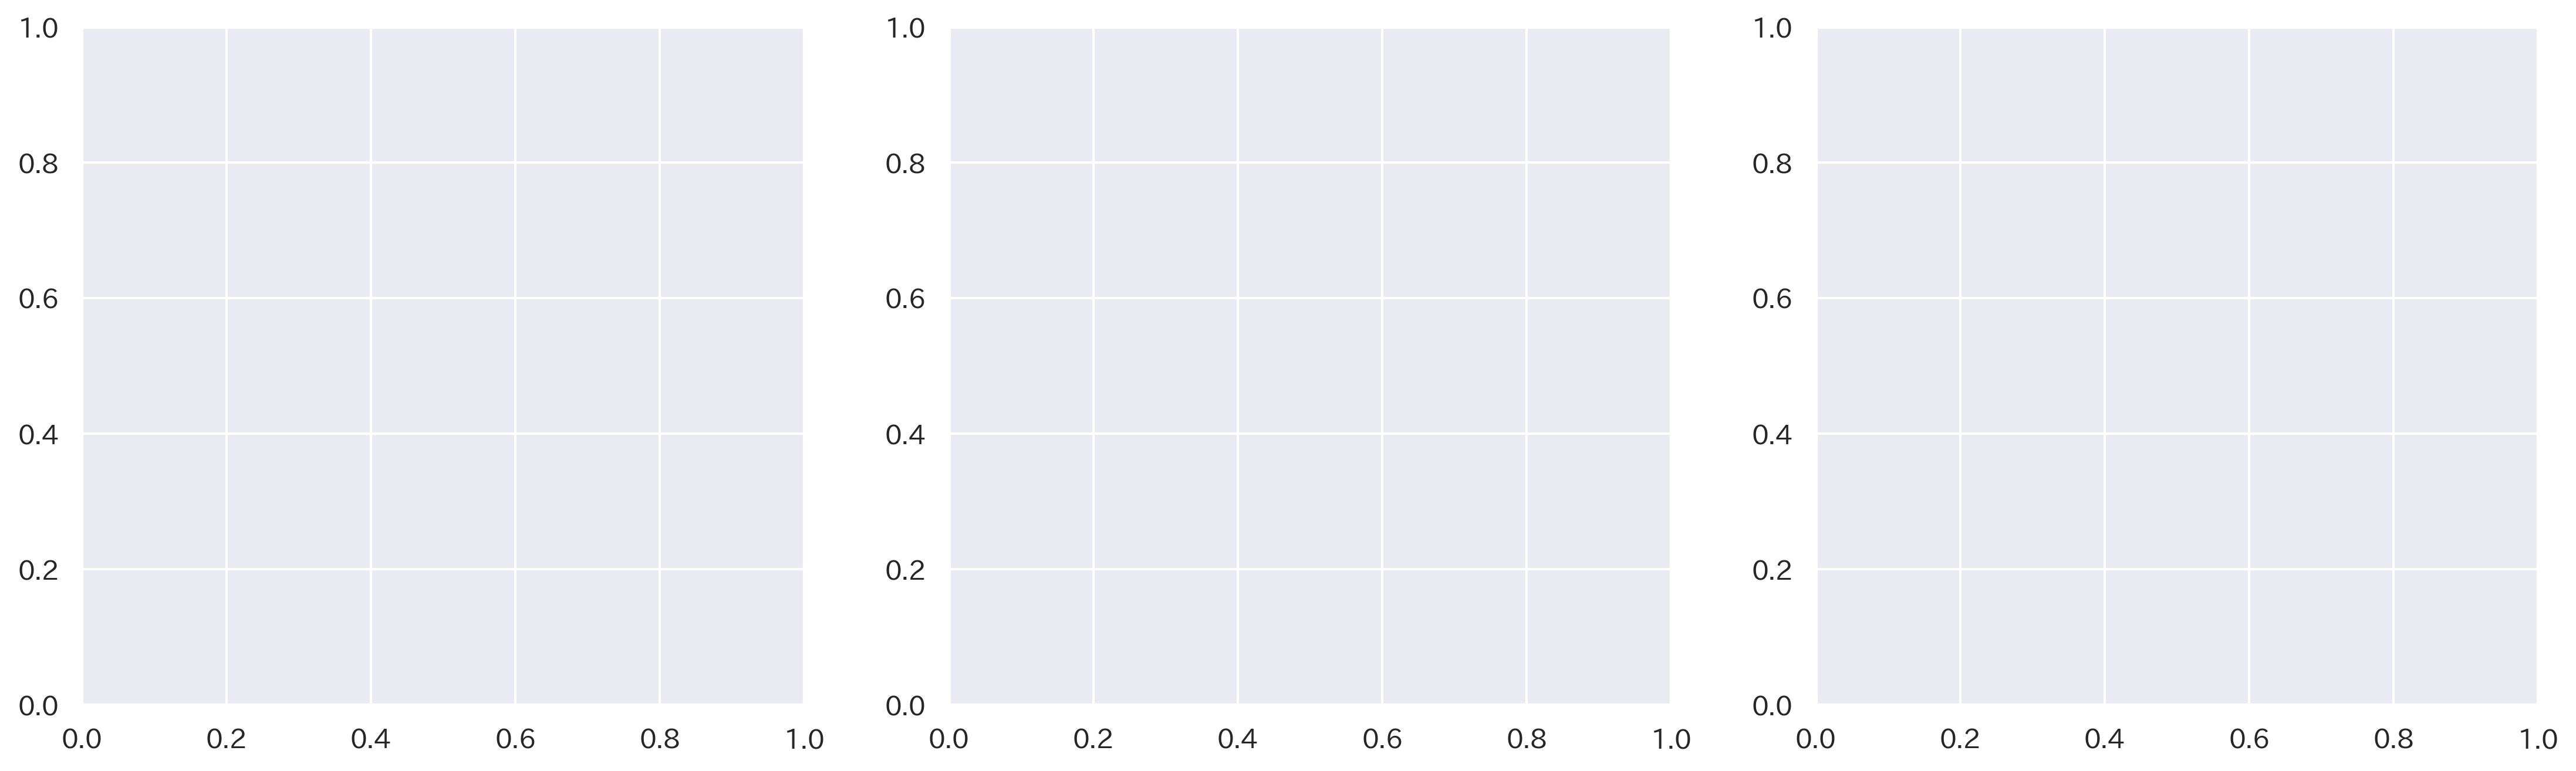

In [104]:
make_graph_from_xlsx(path_to_RawData_folder)